# Finite Markov Chains

### Prepared for the CBC Quantitative Economics Workshop (September 2022)

#### John Stachurski

This is a modified version of the QuantEon [lecture on finite state Markov chains](https://python.quantecon.org/finite_markov.html).

Please uncomment the next line if the `quantecon` library is not installed.

In [52]:
#!pip install quantecon

We will use the following imports.

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe

## Definitions

### Stochastic Matrices


<a id='index-2'></a>
A **stochastic matrix** (or **Markov matrix**)  is an $ n \times n $ square matrix $ P $
such that

1. each element of $ P $ is nonnegative, and  
1. each row of $ P $ sums to one  


Each row of $ P $ can be regarded as a probability mass function over $ n $ possible outcomes.

It is too not difficult to checkthat if $ P $ is a stochastic matrix, then so is the $ k $-th power $ P^k $ for all $ k \in \mathbb N $.

### Markov Chains


<a id='index-4'></a>
There is a close connection between stochastic matrices and Markov chains.

To begin, let $ S $ be a finite set with $ n $ elements $ \{x_1, \ldots, x_n\} $.

The set $ S $ is called the **state space** and $ x_1, \ldots, x_n $ are the **state values**.

A **Markov chain** $ \{X_t\} $ on $ S $ is a sequence of random variables on $ S $ that have the **Markov property**.

This means that, for any date $ t $ and any state $ y \in S $,


<a id='equation-fin-markov-mp'></a>
$$
\mathbb P \{ X_{t+1} = y  \,|\, X_t \}
= \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots \} \tag{24.1}
$$

In other words, knowing the current state is enough to know probabilities for future states.

In particular, the dynamics of a Markov chain are fully determined by the set of values


$$
P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
\qquad (x, y \in S) 
$$

By construction,

- $ P(x, y) $ is the probability of going from $ x $ to $ y $ in one unit of time (one step)  
- $ P(x, \cdot) $ is the conditional distribution of $ X_{t+1} $ given $ X_t = x $  


We can view $ P $ as a stochastic matrix where

$$
P_{ij} = P(x_i, x_j)
\qquad 1 \leq i, j \leq n
$$




### Multiple Step Transition Probabilities


It is not hard to show that the probability of transitioning from $ x $ to $ y $ in
$ m $ steps is $ P^m(x,y) $, the $ (x,y) $-th element of the
$ m $-th power of $ P $.



### Example: Business Cycles

From  US unemployment data, Hamilton [[Ham05](https://python.quantecon.org/zreferences.html#id164)] estimated the stochastic matrix

$$
P_H =
\left(
  \begin{array}{ccc}
     0.971 & 0.029 & 0 \\
     0.145 & 0.778 & 0.077 \\
     0 & 0.508 & 0.492
  \end{array}
\right)
$$

where

- the frequency is monthly  
- the first state represents “normal growth”  
- the second state represents “mild recession”  
- the third state represents “severe recession”  


For example, the matrix tells us that when the state is normal growth, the state will again be normal growth next month with probability 0.97.

In general, large values on the main diagonal indicate persistence in the process $ \{ X_t \} $.

This Markov process can also be represented as a directed graph, with edges labeled by transition probabilities

![https://python.quantecon.org/_static/lecture_specific/finite_markov/hamilton_graph.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/hamilton_graph.png)

  
Here “ng” is normal growth, “mr” is mild recession, etc.

To create $P_H$ in memory we proceed as follows:

In [54]:
P_H = [
    [0.971, 0.029, 0    ],
    [0.145, 0.778, 0.077],
    [0,     0.508, 0.492]
]

In [55]:
type(P_H)

list

In [56]:
P_H = np.array(P_H)

In [57]:
type(P_H)

numpy.ndarray

In [58]:
P_H[0, 0]

0.971

In [59]:
P_H[0, :]

array([0.971, 0.029, 0.   ])

Now that $P_H$ is a NumPy array, we can compute powers by matrix multiplication:

In [60]:
P2_H = P_H @ P_H   # Two step transition probabilities

### Example: Approximation of AR(1) processes

In numerical work, it is sometimes convenient to replace a continuous model with a discrete one.

In particular, Markov chains are routinely generated as discrete approximations to AR(1) processes of the form

$$
     Y_{t+1} = \rho Y_t + U_{t+1}
$$

Here $ (U_t) $ is assumed to be IID and $ N(0, \sigma_u^2) $.    Also, $|\rho| < 1$.

Tauchen’s method is a common method for approximating this continuous state process with a finite state Markov chain.

A routine for this already exists in [QuantEcon.py](http://quantecon.org/quantecon-py) 


In [61]:
ρ, σ_u = 0.9, 0.1
mc = qe.tauchen(ρ, σ_u, n=3)

We have created a `MarkovChain` object:

In [62]:
type(mc)

quantecon.markov.core.MarkovChain

Here's the stochastic matrix:

In [63]:
print(mc.P)

[[9.97047304e-01 2.95269577e-03 0.00000000e+00]
 [2.89531609e-04 9.99420937e-01 2.89531609e-04]
 [2.83186494e-22 2.95269577e-03 9.97047304e-01]]


And here's the state space

In [64]:
mc.state_values

array([-0.6882472,  0.       ,  0.6882472])

## Computing Expectations


<a id='index-18'></a>
We sometimes want to  compute mathematical  expectations of functions of $ X_t $ of the form

<a id='equation-mc-cce'></a>
$$
\mathbb E [ h(X_{t + k})  \mid X_t = x] \tag{24.10}
$$

where

- $ \{X_t\} $ is a Markov chain generated by $ n \times n $ stochastic matrix $ P $  
- $ h $ is a given function, which, in terms of matrix
  algebra, we’ll think of as the column vector  


$$
h
= \left(
\begin{array}{c}
    h(x_1) \\
    \vdots \\
    h(x_n)
\end{array}
  \right)
$$



For the conditional expectation [(24.10)](#equation-mc-cce), we need to sum over
the conditional distribution of $ X_{t + k} $ given $ X_t = x $.

We already know that this is $ P^k(x, \cdot) $, so


<a id='equation-mc-cce2'></a>
$$
\mathbb E [ h(X_{t + k})  \mid X_t = x]
= \sum_{y \in S} P^k(x, y) h(y)
= (P^k h)(x) \tag{24.11}
$$

The vector $ P^k h $ stores the conditional expectation $ \mathbb E [ h(X_{t + k})  \mid X_t = x] $ over all $ x $.

### Expectations of Geometric Sums

Sometimes we want to compute the mathematical expectation of a geometric sum, such as

$$ v(x) := \mathbb{E} \left[ \sum_{t \geq 0} \beta^t h(X_t) \,|\, X_0 = x \right] $$.

In view of the preceding discussion, we have

$$
    v = h + \beta P h + \beta^2 P^2 h + \cdots
$$

In calculating the right-hand side, we can use the Neumann series lemma, which tells us that

$$
    I + \beta P + \beta^2 P^2 + \cdots = (I - \beta P)^{-1} 
$$

Hence

$$ v = (I - \beta P)^{-1} h $$

### Exercise

Use Tauchen's approximation to produce a Markov chain with parameters 

In [65]:
ρ, σ_u, n = 0.9, 0.1, 100

Let $S$ be the associated state space and let $\pi(x) = \exp(x)$.  We consider elements of $S$ as states of the world and $\pi(x)$ as the profit of a given firm in state $x$.

Let $r=0.02$ be the interest rate.

Compute the expected present value of the firm, which is defined as 


$$ v(x) := \mathbb{E} \left[ \sum_{t \geq 0} \left(\frac{1}{1+r}\right)^t \pi(X_t) \,|\, X_0 = x \right] $$.

Plot $v$ as a function of $x$.

Hint: to solve a linear system of equations, use `np.linalg.solve`.
    
To get documentation on this function, try `np.linalg.solve?`

Here's a suggested starting point

In [66]:
r = 0.02
mc = qe.tauchen(ρ, σ_u, n=n)
P = mc.P
S = mc.state_values
β = 1/(1 + r)

In [67]:
# Put your code here

In [68]:
for _ in range(10):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


Applying the rules for computing geometric sums above, we proceed as follows:

In [69]:
π = np.exp(S)
I = np.identity(n)
v = np.linalg.solve(I - β * P, π)

Now let's plot:

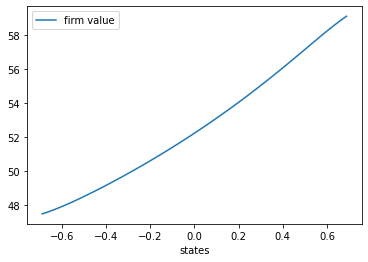

In [70]:
fig, ax = plt.subplots()
ax.plot(S, v, label='firm value')
ax.set_xlabel('states')
ax.legend()
plt.show()

## Stationary Distributions

Let $P$ be a stochastic matrix on finite set $S$.

A distribution (i.e., probability mass function) $\psi$ on the state space $S$ is called *stationary* or *invariant* for $P$ of $\psi = \psi P$, where $\psi$ is treated as a row vector.

The matrix $P$ is called *irreducible* if, for each $x,y \in S$, there exists a nonnegative integer $k$ such that $P^k(x, y) > 0$.

**Theorem.** If $P$ is irreducible then $P$ has exactly one stationary distribution $\psi$.  Moreover, $\psi$ is the unique dominant left eigenvector of $P$, normalized to sum to $1$.

(If $P$ is stochastic, then, by the Perron-Frobenius theorem, the largest eigenvalue is $1$ and the dominant eigenvector is the eigenvector corresponding to $1$.)

We can compute stationary distributions using the routines in `qe.MarkovChain`.  For example,

In [71]:
mc = qe.MarkovChain(P_H)

In [72]:
mc.is_irreducible

True

In [73]:
mc.stationary_distributions[0]

array([0.8128 , 0.16256, 0.02464])

### Exercise

Write a function to compute the stationary distribution of a stochastic matrix $P$ as the dominant eigenvector of $P$.

Hints: 

* To compute the left eigenvectors of $P$, compute the (ordinary) right eigenvectors of $P^\top$.
* Try running `numpy.linalg.eig?`

In [74]:
# Put your code here

In [75]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [76]:
def compute_stationary(P):
    # Compute the eigenvalues and left eigenvectors of P
    eigvals, eigvecs = np.linalg.eig(P.T)
    # Extract the eigenvector corresponding to the largest eigenvalue
    i = np.argmax(np.abs(eigvals))
    p = eigvecs[:, i]
    # Drop any complex parts, which are trivial 
    p = np.real(p)
    # Return the vector, normalized to sum to 1
    return p / np.sum(p)

Let's test that it works for the matrix $P_H$.

In [77]:
compute_stationary(P_H)

array([0.8128 , 0.16256, 0.02464])

### Exercise

Another way to solve for the solution to $\psi = \psi P$, where $\psi$ is a row vector, is to use matrix inversion.

One issue here is that the zero vector is a solution.

As a result, we solve instead for the solution to 

$$ (I - P^\top + 1_{n \times n}) \psi^\top = 1_{n \times 1} $$

where 

* $n$ is the size of the state space
* $I$ is the $n \times n$ identity
* $1_{j \times k}$ is a $j \times k$ matrix of ones.

Write a function to accomplish this task for any stochastic matrix $P$.

In [78]:
# Put your code here

In [79]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [80]:
def compute_stationary_2(P):
    n = len(P)
    I = np.identity(n)
    O = np.ones((n, n))
    A = I - P.T + O
    return np.linalg.solve(A, np.ones(n))

Let's check that it works for $P_H$.

In [81]:
compute_stationary_2(P_H)

array([0.8128 , 0.16256, 0.02464])

## Simulation


<a id='index-5'></a>
One natural way to answer questions about Markov chains is to simulate them.

(To approximate the probability of event $ E $, we can simulate many times and count the fraction of times that $ E $ occurs).

Nice functionality for simulating Markov chains exists in [QuantEcon.py](http://quantecon.org/quantecon-py).

- Efficient, bundled with lots of other useful routines for handling Markov chains.  


However, it’s also a good exercise to roll our own routines — let’s do that first and then come back to the methods in [QuantEcon.py](http://quantecon.org/quantecon-py).

In these exercises, we’ll take the state space to be $ S = 0,\ldots, n-1 $.

### Rolling Our Own

To simulate a Markov chain, we need its stochastic matrix $ P $ and a marginal probability distribution $ \psi $  from which to  draw a realization of $ X_0 $.

The Markov chain is then constructed as discussed above.  To repeat:

1. At time $ t=0 $, draw a realization of  $ X_0 $  from $ \psi $.  
1. At each subsequent time $ t $, draw a realization of the new state $ X_{t+1} $ from $ P(X_t, \cdot) $.  


To implement this simulation procedure, we need a method for generating draws from a discrete distribution.

For this task, we’ll use `random.draw` from [QuantEcon](http://quantecon.org/quantecon-py), which works as follows:

In [82]:
ψ = (0.3, 0.7)           # probabilities over {0, 1}
cdf = np.cumsum(ψ)       # convert into cummulative distribution
qe.random.draw(cdf, 5)   # generate 5 independent draws from ψ

array([0, 0, 1, 1, 1])

We’ll write our code as a function that accepts the following three arguments

- A stochastic matrix `P`  
- An initial state `init`  
- A positive integer `sample_size` representing the length of the time series the function should return  

In [83]:
def mc_sample_path(P, ψ_0=None, sample_size=1_000):

    # set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)

    # Convert each row of P into a cdf
    n = len(P)
    P_cdf = np.cumsum(P, axis=1)

    # draw initial state, defaulting to 0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0

    # simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_cdf[X[t]])

    return X

Let’s see how it works using the small matrix

In [84]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

For a long series drawn from `P`, the fraction of the sample that takes value 0 will be about 0.25.

Moreover, this is true, regardless of the initial distribution from which
$ X_0 $ is drawn.

The following code illustrates this

In [85]:
X = mc_sample_path(P, ψ_0=[0.1, 0.9], sample_size=100_000)
np.mean(X == 0)

2.4889e-01

You can try changing the initial distribution to confirm that the output is
always close to 0.25, at least for the `P` matrix above.

### Using QuantEcon’s Routines

As discussed above, [QuantEcon.py](http://quantecon.org/quantecon-py) has routines for handling Markov chains, including simulation.

Here’s an illustration using the same P as the preceding example

In [86]:
from quantecon import MarkovChain

mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.249595

The [QuantEcon.py](http://quantecon.org/quantecon-py) routine is [JIT compiled](https://python-programming.quantecon.org/numba.html#numba-link) and much faster.

In [87]:
%time mc_sample_path(P, sample_size=1_000_000) # Our homemade code version

CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 519 ms


array([0, 0, 1, ..., 1, 0, 1])

In [88]:
%time mc.simulate(ts_length=1_000_000) # qe code version

CPU times: user 12 ms, sys: 3.22 ms, total: 15.2 ms
Wall time: 14.7 ms


array([1, 0, 1, ..., 0, 1, 1])

### Exercise

Let $P$ be a stochastic matrix on finite set $S$.

**Theorem.** If $P$ is irreducible then $P$ is ergodic; that is, if $h \colon S \to \mathbb R$, then

$$ 
    \mathbb P
    \left\{
    \lim_{k \to \infty} \frac{1}{k} \sum_{t=0}^{k-1} h(X_t) = \sum_y h(y) \psi(y)
    \right\} = 1
$$

whenever $\{X_t\}$ is a Markov chain generated by $P$.

(Notice that the initial condition $X_0$ does not matter---the result is independent of the initial condition.)

Verify this claim when $P$ is a Tauchen approximation of an AR(1) process with $\rho=0.9$, $\sigma_u = 0.1$ and $n=100$.

Set $h(x) = x^2$.

(In this case, we are verifying the claim that the sample second moment equals the cross-sectional population second moment.)

In [106]:
# Put your code here

In [107]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [108]:
mc = qe.tauchen(0.9, 0.1, n=100)
S = mc.state_values
P = mc.P

Let's check irreducibility:

In [109]:
mc.is_irreducible

True

In [111]:
h = lambda x: x**2

k = 10_000_000
X = mc.simulate(k)

The population moment is

In [112]:
h(S) @ compute_stationary(P)

0.05200420463243313

The sample moment is

In [113]:
np.mean(h(X))

0.0520018741288483

As anticipated by the theorem, the two values are close.